# INF8111 - Fouille de données
## Automne 2025 - TP2 - Analyse d'association / Association analysis
### Membres de l'équipe
    1 - Hirab, Alexis - 2146972
    2 - Lefrancois Justin - 2149244 

## Date et directives de remise

Vous devez remettre dans la boîte de remise sur moodle ce fichier nommé TP2_NumeroEquipe_matricule1_matricule2_matricule3.ipynb

**N.B**: Assurez-vous que tous les résultats soient lisibles lorsque le notebook est ouvert.

Ce notebook doit être remis avant le **15 novembre 2025 à 23h59**. Tout travail en retard sera pénalisé d’une valeur de 10\% par jour de retard.


In [24]:
# Vous pouvez installer les packages

! pip install openpyxl
! pip install mlxtend
! pip install missingno
! pip install networkx

/Users/alexishirab/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=35346) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/Users/alexishirab/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=35346) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/Users/alexishirab/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=35346) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/Users/alexishirab/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=35346) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [25]:
# Vérifier si les librairies sont bien installées : un exemple
import matplotlib.pyplot as plt
import networkx
print('networkx: {}'.format(networkx.__version__))

networkx: 3.5


## 0. Introduction: Analyse d'association

###  Présentation

En fouille de données, l'analyse d'association est une technique utile pour trouver des relations intéressantes dans de grands ensembles de données. Un exemple typique d'analyse d'association est l'analyse du panier de consommation(***market basket analysis***). Cette section fournit les motivations du TP pour l'utilisation de cette forme de règle d'association.

Supposons que vous êtes responsable d'un cabinet de conseil en fouille et analyse de données. Votre cabinet est contacté par un détaillant dans le but d'en savoir plus sur les habitudes d'achat de ses clients. Plus précisément, votre mission pour ce détaillant est de répondre à la question suivante :  "*_Quels groupes ou ensembles d'articles les clients sont-ils susceptibles d'acheter lors d'une visite donnée au magasin ?_* ". Pour répondre à cette question, vous décidez d'appliquer une analyse du panier de consommation à partir des données de vente mises à votre disposition par le détaillant. Les résultats pourront être utilisés pour planifier des stratégies marketing ou publicitaires, ainsi que pour la conception de catalogues. À titre d'exemple, pour une stratégie, les articles fréquemment achetés ensemble peuvent être placés à proximité les uns des autres afin d'encourager davantage la vente de tels articles ensemble. Dans une stratégie alternative, placer ces articles aux extrémités opposées du magasin peut inciter les clients qui achètent ces articles à en acheter d'autres en cours de route.


### But du TP

Le but de ce TP est de vous donner un aperçu de l'analyse des règles d'association à travers un cas pratique sur des données réelles.

Dans la première partie, vous allez préparer les données et répondre à certaines questions générales sur l'ensemble des données.

Dans la deuxième partie, vous aller générer des règles d'association premièrement avec l'algorithme a-priori et ensuite avec l'algorithme FP-growth proposé par [Jiawei Han, Jian Pei, Yiwen Yin](https://www.cs.sfu.ca/~jpei/publications/sigmod00.pdf?utm_source=chatgpt.com) que vous aurez implémenté.

### Aperçu du dataset

In [26]:
# Exécution avec le notebook Google Colab

# from google.colab import drive
# # Mount Google Drive
# drive.mount('/content/drive')

# #  Chemin vers ton fichier (à adapter selon ton dossier dans Drive)
# # file_path = "/content/drive/MyDrive/INF8111/TP A25/TP2/retail_dataset.xlsx"



# Chemin vers ton dataset : local
file_path = "retail_dataset.xlsx"


Nous vous avons fourni le fichier *`retail_dataset.xlsx`* . Il contient l'ensemble des données. Chaque ligne contient les données d'une vente. La description des attributs du dataset est la suivante:

| # | Feature Name | Description |
|---|--------------|-------------|
| 1 | InvoiceNo    | Numéro de facture / Identifiant unique de chaque transaction (6 chiffres, commence par 'C' si annulation). |
| 2 | StockCode    | Code produit / Identifiant unique (5 chiffres) attribué à chaque produit distinct. |
| 3 | Description  | Nom du produit / Désignation textuelle du produit. |
| 4 | Quantity     | Quantité / Nombre d’unités du produit dans la transaction. |
| 5 | InvoiceDate  | Date de la transaction / Jour et heure où la transaction a été générée. |
| 6 | UnitPrice    | Prix unitaire / Prix du produit par unité. |
| 7 | CustomerID   | Identifiant client / Code unique (5 chiffres) attribué à chaque client. |
| 8 | Country      | Pays du client / Nom du pays de résidence du client. |



In [27]:
import pandas as pd

df= pd.read_excel(file_path)
df.head(-1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France


## 1.  Préparartion de données et analyse de base (25 point)

### 1.1. Valeurs manquantes

#### Question 1 (3 points )

Combien y a-t-il de valeurs manquantes ? Supprimer toutes les lignes ayant de valeurs manquantes et rassurez-vous d'avoir aucune valeur manquante après suppresion.

In [28]:
print("Nombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

print("\nNombre total de valeurs manquantes :", df.isnull().sum().sum())

df = df.dropna()


Nombre de valeurs manquantes par colonne :
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Nombre total de valeurs manquantes : 136534


In [29]:
# En décommentant la ligne suivante, le nombre 0 devrait apparaitre à l'exécution

df.isnull().values.sum()

np.int64(0)

#### Question 2 (3 points)
La colonne "InvoiceNo" contient sur chaque ligne un numéro entier à 6 chiffres attribué de manière unique à chaque transaction. Si ce code commence par la lettre «C», il indique une annulation.

Supprimer maintenant les factures annulées et indiquer le nombre de lignes avant et après suppression.

In [30]:
# TO DO
print("Nombre de ligne avant supression de transactions annulées: ", len(df))
df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]
print("Nombre de ligne après supression de transactions annulées: ", len(df))


Nombre de ligne avant supression de transactions annulées:  406829
Nombre de ligne après supression de transactions annulées:  397924


#### Question 3 (4 points)
La description du fichier fourni par le détaillant indique que l'attribut "StockCode" est un identifiant unique à ***5 chiffres*** attribué à chaque produit distinct. Malgré cette information, le spécialiste en fouille de données que vous êtes décide de vérifier cette information.


Quelles sont les valeurs uniques de l'attribut "StockCode" dont la longueur est plus pétite que 5? Supprimer les lignes de ces valeurs et indiquer le nombre de lignes après cette suppression.

In [31]:
# TO DO
print("Nombre de valeurs uniques de 'StockCode' :", len(df["StockCode"].unique()))
print(df["StockCode"].unique())


rows_removed = df["StockCode"].astype(str).str.len() < 5
print("\nValeurs uniques de 'StockCode' de longueur < 5 :", len(df.loc[rows_removed, "StockCode"].unique()))
print(df.loc[rows_removed, "StockCode"].unique())

df = df[~rows_removed]
print("\nNombre de lignes après suppression :", len(df))

Nombre de valeurs uniques de 'StockCode' : 3665
['85123A' 71053 '84406B' ... '90214Z' 90089 23843]

Valeurs uniques de 'StockCode' de longueur < 5 : 5
['POST' 'C2' 'M' 'PADS' 'DOT']

Nombre de lignes après suppression : 396382



### 1.2. Analyse basique
#### Questions 4 (15 points)

Pour explorer ces données, on commence par répondre à ces questions.

#### Question 4.a. (5 points)
Quels sont les 10 premiers articles les plus vendus en terme de quantité d'articles ? Indiquer les quantités correspondantes. Un diagramme en barres est attendu.

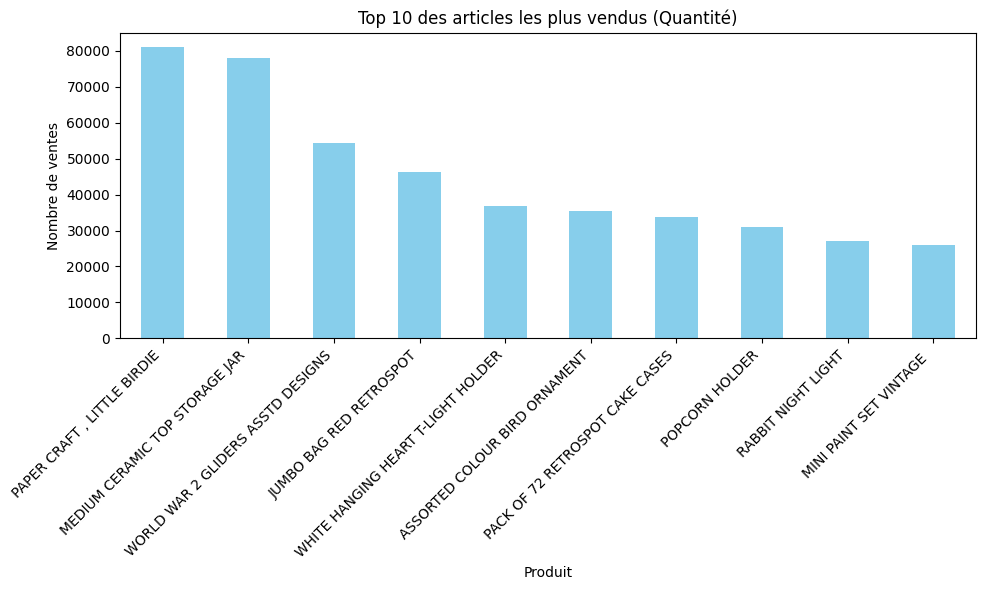

In [32]:
top10 = (
    df.groupby("Description")["Quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
top10.plot(kind="bar", color="skyblue")
plt.title("Top 10 des articles les plus vendus (Quantité)")
plt.xlabel("Produit")
plt.ylabel("Nombre de ventes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Question 4.b. (5 points)
Quels sont les 10 premiers articles les plus vendus en terme de prix ? Un diagramme en barres est attendu.

NB : Tous les prix sont en même devise.

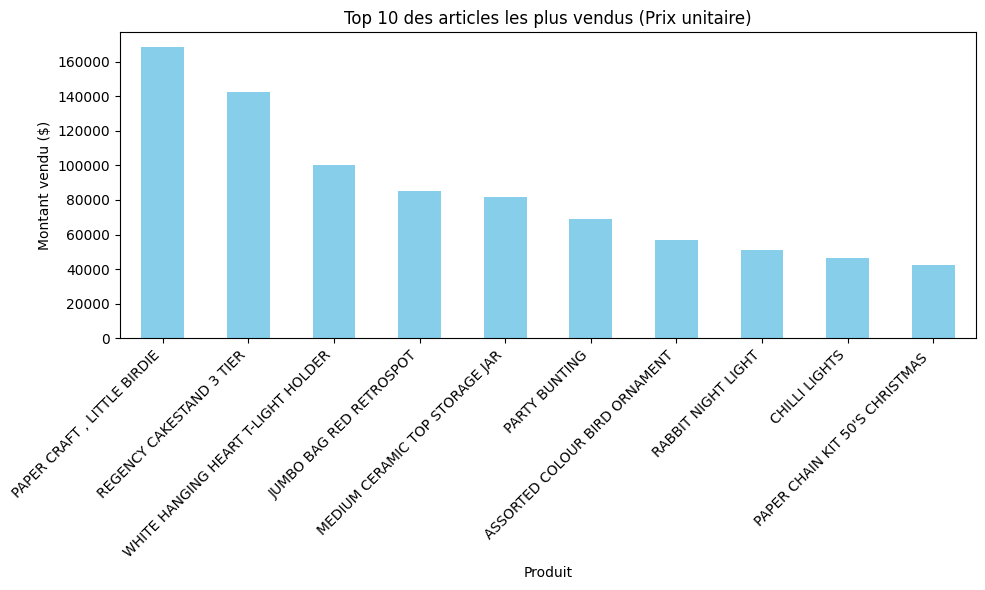

In [33]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

top10 = (
    df.groupby("Description")["TotalPrice"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
top10.plot(kind="bar", color="skyblue")
plt.title("Top 10 des articles les plus vendus (Prix unitaire)")
plt.xlabel("Produit")
plt.ylabel("Montant vendu ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Question 4.c. (5 points)
Sachant qu'il s'agit d'un détaillant britanique, son chiffre d'affaire à l'international est plus élevé que son chiffre d'affaire au Royaume-Uni ?

In [34]:
vente_RU = df.loc[df["Country"] == "United Kingdom", "TotalPrice"].sum().round(2)
vente_Inter = df.loc[df["Country"] != "United Kingdom", "TotalPrice"].sum().round(2)

if(vente_RU > vente_Inter):
    print("Le chiffre d'affaire à l'international n'est pas plus élevé que son chiffre d'affaire au Royaume-Uni, soit: \n")
elif(vente_RU < vente_Inter):
    print("Le chiffre d'affaire à l'international est plus élevé que son chiffre d'affaire au Royaume-Uni, soit: \n")

print("Vente au Royaume-Uni: ", vente_RU, "$")
print("Vente à l'international: ", vente_Inter, "$")


Le chiffre d'affaire à l'international n'est pas plus élevé que son chiffre d'affaire au Royaume-Uni, soit: 

Vente au Royaume-Uni:  7266027.23 $
Vente à l'international:  1495204.42 $


### 1.3. Prépararation de données - Représentation des données de transactions

La colonne "Description" de ce dataset contient plus de 3500 valeurs uniques. Pour notre analyse de règles d'association, nous voudrions regrouper les articles par catégorie.

Nous avons fourni le fichier ***group.csv*** qui contient pour chaque description d'article, le nom de son groupe d'article.

Nous fournissons le code ci-dessous qui permet de modifier le dataframe de telle sorte à obtenir une colonne supplémentaire dénommée "Group" comportant le nom de groupe des articles.

In [35]:
import pandas as pd
import json

with open("grouped.json", "r") as f:
    familles_dict = json.load(f)


mapping = {}
for famille, objets in familles_dict.items():
    for obj in objets:
        mapping[obj.upper()] = famille

df["Description_clean"] = df["Description"].str.upper().str.strip()
df["Group"] = df["Description_clean"].map(mapping)
df = df.dropna(subset=["Group"])

# Afficher
print(df[["Description", "Group"]].head())


                           Description          Group
0   WHITE HANGING HEART T-LIGHT HOLDER     DECORATION
1                  WHITE METAL LANTERN  MISCELLANEOUS
2       CREAM CUPID HEARTS COAT HANGER     DECORATION
3  KNITTED UNION FLAG HOT WATER BOTTLE       TEXTILES
4       RED WOOLLY HOTTIE WHITE HEART.     DECORATION


#### Question 5 (5 points)
Pour l'analyse des règles d'association, on a besoin des paniers. Dans le dataset, chaque ligne correspond à un achat de produit. Plusieurs lignes peuvent avoir le même Invoice si un client a acheté plusieurs produits en une seule commande. On veut obtenir pour chaque panier, et par conséquent pour chaque InVoiceNo, tous les produits achetés ensemble dans la même facture.

A titre d'exemple, on aura :

| InvoiceNo | Panier               |
| ------- | -------------------------------- |
| 536365    | ['FOOD STORAGE', 'LIGHTING', 'DECORATION', 'TEXTILES', 'MISCELLANEOUS'] |
| 536367    | ['TOYS', 'CUSHIONS & COVERS', 'DECORATION', 'VINTAGE & RETRO', 'KITCHENWARE', 'MISCELLANEOUS', 'CRAFTS & SEWING']                 |





In [36]:
df_paniers = (
    df.groupby("InvoiceNo")["Group"]
    .apply(list)
    .reset_index(name="Panier")
)

In [37]:
# Décommentez la ligne suivante
df_paniers

,InvoiceNo,Panier
0,536365,"[DECORATION, MISCELLANEOUS, DECORATION, TEXTIL..."
1,536366,"[MISCELLANEOUS, MISCELLANEOUS]"
2,536367,"[DECORATION, TOYS, CRAFTS & SEWING, KITCHENWAR..."
3,536368,"[FOOD STORAGE, MISCELLANEOUS, MISCELLANEOUS, M..."
4,536369,[BATHROOM & TOILETRIES]
...,...,...
18322,581583,"[LUNCH & DINNER, LIGHTING]"
18323,581584,"[DECORATION, LIGHTING]"
18324,581585,"[TEXTILES, DECORATION, LIGHTING, PETS & ANIMAL..."
18325,581586,"[DECORATION, VINTAGE & RETRO, VINTAGE & RETRO]"


#### Question 6 (5 points)
Effectuer l'encodage **One hot** sur l'ensemble des paniers avec la classe ***TransactionEncoder*** du module **_preprocessing_** de la librairie **_mlxtend._**. Le dataframe **df_encoded** doit contenir des colonnes qui représentent les noms des groupes de produits où chaque ligne de booléens représente un panier.  

In [38]:
from mlxtend.preprocessing import TransactionEncoder

transactions = df_paniers["Panier"].tolist()

encoder = TransactionEncoder()
df_encoded = encoder.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(df_encoded, columns=encoder.columns_)


In [39]:
# Décommentez la ligne suivante
df_encoded.head()

,ACCESSORIES & PURSES,BABY & CHILD,BAGS & SHOPPERS,BATHROOM & TOILETRIES,CANDLES,CARDS & WRAPPING,CHRISTMAS & HOLIDAYS,CHRISTMAS LIGHTS,CLOCKS & ALARMS,CRAFTS & SEWING,...,MISCELLANEOUS,PARTY & CELEBRATIONS,PETS & ANIMALS,SIGNS & WALL ART,STATIONERY,TABLEWARE,TEXTILES,TOYS,UMBRELLAS & RAINWEAR,VINTAGE & RETRO
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,True,False,True
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 2. Analyse de règles d'association (75 points)

#### 2.1. Apriori


#### Question 7 (15 points)

L’algorithme **Apriori** permet de découvrir des règles d’association dans un ensemble de transactions. L’idée est de trouver quels articles sont souvent achetés ensemble, puis de formuler des règles du type : *si un client achète X, il achètera probablement Y*. Dans cette section de ce TP, nous allons appliquer Apriori pour extraire les itemsets fréquents et générer des règles d’association. Cet algorithme utilise une approche par niveaux pour générer des règles d'association, chaque noveau correspondant au nombre d'éléments appartenant à la conséquence de la règle.

En utilisant la librairie **_mlxtend_**,  on peut extraire les itemsets fréquents pour l'algorithme ***Apriori*** puis générer les règles d’association.

#### Question 7.1 (7.5 points)
Pour les valeurs de min_support allant de 0.1 à 0.5 avec une plage de 0.05, tracer une courbe indiquant le nombre de groupes d'articles fréquents pour chacune de ces valeurs de min_support.

Sur un autre graphe, tracer le temps d'exécution de l'algorithme Apriori pour chacune de ces valeurs de min_support.

Ensuite, interprétez ce que vous observer pour chacune de ces courbes.

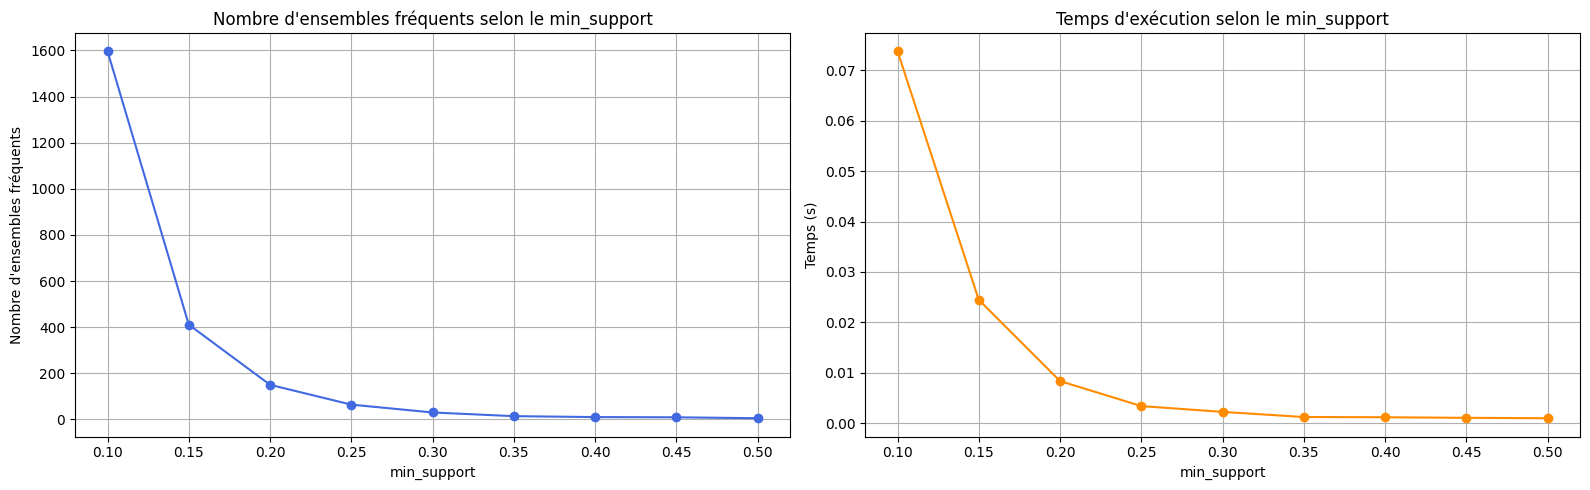

In [40]:
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
import time as time

supports = [round(x, 2) for x in np.arange(0.1, 0.55, 0.05)]

nb_itemsets = []
execution_times = []

for s in supports:
    start_time = time.time()
    freq_items = apriori(df_encoded, min_support=s, use_colnames=True)
    
    elapsed_time = time.time() - start_time
    freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))

    nb_itemsets.append(freq_items['length'].sum())
    execution_times.append(elapsed_time)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(supports, nb_itemsets, marker="o", color="royalblue")
axes[0].set_title("Nombre d'ensembles fréquents selon le min_support")
axes[0].set_xlabel("min_support")
axes[0].set_ylabel("Nombre d'ensembles fréquents")
axes[0].grid(True)

axes[1].plot(supports, execution_times, marker="o", color="darkorange")
axes[1].set_title("Temps d'exécution selon le min_support")
axes[1].set_xlabel("min_support")
axes[1].set_ylabel("Temps (s)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

À l'aide des graphiques, on constate que plus le seuil du support minimal augmente, moins il y a d’items fréquents, ce qui correspond à la théorie des règles d'associations. Un seuil plus élevé diminue le nombre d’items fréquents, ce qui réduit ainsi le nombre de combinaisons possibles. De plus, le temps d’exécution diminue aussi, puisqu’il y a moins d’ensembles fréquents à compiler et à analyser.

#### Question 7.2 (7.5 points)
Fixer la valeur de ***min_support=0.3***. Pour les valeurs de min_confidence allant de 0.05 à 0.8 avec une plage de 0.05, tracer une courbe indiquant le nombre de règles pour chacune de de ces valeurs de min_confidence. Donner une interprétation du résultat obtenu.

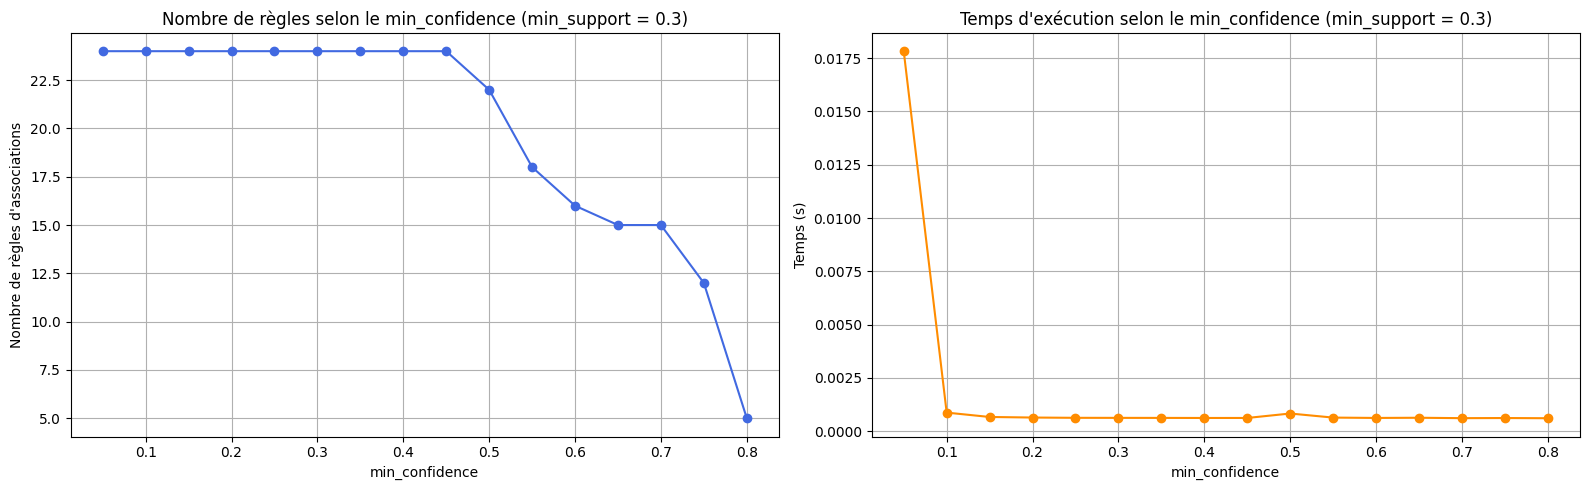

In [41]:
freq_items = apriori(df_encoded, min_support=0.3, use_colnames=True)

confidences = [round(x, 2) for x in np.arange(0.05, 0.85, 0.05)]

nb_rules = []
execution_times = []

for c in confidences:
    start_time = time.time()
    rules = association_rules(freq_items, metric="confidence", min_threshold=c)
    elapsed_time = time.time() - start_time

    nb_rules.append(len(rules))
    execution_times.append(elapsed_time)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(confidences, nb_rules, marker="o", color="royalblue")
axes[0].set_title("Nombre de règles selon le min_confidence (min_support = 0.3)")
axes[0].set_xlabel("min_confidence")
axes[0].set_ylabel("Nombre de règles d'associations")
axes[0].grid(True)

axes[1].plot(confidences, execution_times, marker="o", color="darkorange")
axes[1].set_title("Temps d'exécution selon le min_confidence (min_support = 0.3)")
axes[1].set_xlabel("min_confidence")
axes[1].set_ylabel("Temps (s)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

On observe que le nombre de règles d’association diminue lorsque la confiance minimale augmente. Cela s’explique par le fait qu’un seuil de confiance plus élevé rend les conditions plus strictes, donc seules les règles les plus fiables sont conservées. Ainsi, comme on le voit, à partir d’un certain seuil, soit 0.5, beaucoup de règles sont éliminées, car elles ne satisfont plus le critère de confiance.

De plus, le temps d’exécution diminue également, puisque moins de règles sont générées et évaluées lorsque le seuil de confiance devient plus exigeant. Bref, un seuil de confiance faible permet de produit plus de règles, même si certaines redondantes, tandis qu’un seuil plus élevé diminue ce nombre, mais augmente leur fiabilité/confiance.

### 2.2 FP-growth

Apriori fonctionne en générant systématiquement tous les candidats possibles et en vérifiant pour chacun leur support. Cette méthode devient rapidement **lente et coûteuse** lorsque le nombre d’items fréquents augmente. Des méthodes alternatives ont été développées pour surmonter les limites et améliorer l'efficacité de l'algorithme Apriori.

FP-growth, ou **Frequent Pattern Growth**, propose une approche plus efficace. Au lieu de générer tous les candidats, FP-growth utilise une structure de données compacte appelée **FP-tree** pour les transactions fréquentes. L’idée est la suivante : représenter les transactions sous forme d’arbre, où les chemins partagés entre transactions sont fusionnés, ce qui réduit considérablement le nombre d’opérations nécessaires.

Pour construire un FP-tree, on commence par compter la **fréquence de chaque item** dans l’ensemble des transactions et on élimine les items peu fréquents (ceux dont le support est inférieur à un seuil minimum). Les items restants sont ensuite **triés par ordre décroissant de fréquence**. Chaque transaction devient un chemin dans l’arbre, en suivant cet ordre. Les transactions partageant des items fréquents communs se superposent dans l’arbre, ce qui permet de représenter toutes les transactions de manière très compacte.

Une fois l’arbre construit, l’extraction des itemsets fréquents se fait en parcourant l’arbre à partir des items les moins fréquents (en bas de la table de liens ou "header table") et en combinant les chemins pour générer des patterns fréquents. Contrairement à Apriori, FP-growth **ne génère jamais tous les candidats possibles** : il utilise la structure de l’arbre pour extraire directement les itemsets fréquents, ce qui rend la méthode beaucoup plus rapide et efficace, surtout pour les datasets volumineux ou contenant de nombreux items fréquents.


Dans cette section du TP, vous allez implémenter FP-growth, sans utiliser des librairies spécialisées pour les règles d’association.

#### 2.2.1 Construction d’un FP-tree
Dans l’algorithme **FP-Growth**, l’étape clé consiste à construire un **FP-tree (Frequent Pattern Tree)**.  Cet arbre est construit en mappant chaque transaction sur un chemin dans l'arbre. Comme différentes transactions peuvent avoir plusieurs articles en commun, leurs chemins peuvent se chevaucher. Ainsi, plus les données se chevauchent, plus on peut obtenir une compression importante.

#### Question 8 (20 points)

On vous demande de compléter la fonction ***build_fp_tree*** qui :  

1. Compte la fréquence de chaque item et calcule son support.  
2. Élimine les items dont le support est inférieur à `min_support`.  
3. Trie les items de chaque panier par ordre décroissant de support.  
4. Construit un **arbre orienté (FP-tree)** où :  
   - La racine est un nœud `"root"`. Chaque panier trié commence toujours par le nœud `"root"`.
   - Chaque chemin correspond à un panier filtré et trié.  
   - Chaque nœud contient un compteur indiquant le nombre de paniers dans lesquels il apparaît.  


In [42]:

from collections import Counter

def build_fp_tree(transactions, min_support):
    tree = {"item": "root", "count": 0, "children": {}}

    if not transactions:
        return tree

    total_transactions = len(transactions)

    # 1 : fréquence et support par item
    item_counts = Counter()
    for basket in transactions:
        item_counts.update(set(basket))
    item_support = {
        item: count / total_transactions for item, count in item_counts.items()
    }

    # 2 : filtrer les items qui ne respectent pas min_support
    frequent_items = {
        item: count for item, count in item_counts.items()
        if item_support[item] >= min_support
    }
    if not frequent_items:
        return tree

    # 3 et 4 : trier chaque panier et construire l'arbre
    for basket in transactions:
        filtered = [item for item in basket if item in frequent_items]
        if not filtered:
            continue

        seen = set()
        unique_filtered = []
        for item in filtered:
            if item not in seen:
                unique_filtered.append(item)
                seen.add(item)

        ordered_items = sorted(
            unique_filtered,
            key=lambda item: (-item_support[item], item)
        )

        current_node = tree
        current_node["count"] += 1
        for item in ordered_items:
            if item not in current_node["children"]:
                current_node["children"][item] = {"item": item, "count": 0, "children": {}}
            current_node = current_node["children"][item]
            current_node["count"] += 1

    return tree

Utilisez la fonction test_fp_tree pour vérifier votre implémentation de la fonction précédente sur. Afficher le graphe obtenu en tenant compte de votre structure de données. Un type particulier d'affichage n'est pas exigé.  


In [43]:
def test_fp_tree():
    transactions = [['a', 'b', 'c'], ['a', 'b', 'c', 'd'], ['b', 'c', 'e'], ['a', 'c', 'd', 'e'], ['d', 'e']]

    tree = build_fp_tree(transactions, 0.0)

    def display(node):
        print(f"{node['item']} ({node['count']})")

        def _display(children, prefix):
            children = sorted(children, key=lambda n: (-n['count'], n['item']))
            for idx, child in enumerate(children):
                is_last = idx == len(children) - 1
                connector = '└── ' if is_last else '├── '
                label = f"{child['item']} ({child['count']})"
                print(f"{prefix}{connector}{label}")
                child_prefix = prefix + ('    ' if is_last else '│   ')
                _display(child['children'].values(), child_prefix)

        _display(node['children'].values(), '')

    display(tree)

test_fp_tree()


root (5)
├── c (4)
│   ├── a (3)
│   │   ├── b (2)
│   │   │   └── d (1)
│   │   └── d (1)
│   │       └── e (1)
│   └── b (1)
│       └── e (1)
└── d (1)
    └── e (1)


#### 2.2.2  Extraction des itemsets fréquents dans l'algirithme FP-Growth.
####  Question 9 (10 points)

Dans cette section du TP, nous allons exploiter le précédent **FP-tree** déjà construit.  
Le FP-tree contient des items **triés par fréquence décroissante**, et chaque nœud a un attribut indiquant le nombre de transactions passant par ce nœud.

Votre tâche est d’écrire une fonction `rule_generation(G, min_conf)` qui  :

1. Explore tous les chemins du FP-tree.
2. Pour chaque chemin, construit les **itemsets associés**. La génération de règles se fait à partir de ces itemsets. La confiance se calcule pour chaque règle candidate.
3. Ne retienne les règles que si `confidence ≥ min_conf`.

Il s'agit d'un procédé qui évite de générer toutes les combinaisons globales mais seulement celles soutenues par la structure du FP-tree.

In [44]:
from itertools import combinations

def rule_generation(tree, min_conf):
    if not tree or tree.get('count', 0) == 0:
        return []

    total_transactions = tree['count']
    itemset_support = {}

    def traverse(node, prefix):
        for child in node['children'].values():
            current_prefix = prefix + [child['item']]
            key = frozenset(current_prefix)
            itemset_support[key] = child['count']
            traverse(child, current_prefix)

    traverse(tree, [])

    rules = []
    for itemset, count in itemset_support.items():
        if len(itemset) < 2:
            continue
        support = count / total_transactions
        sorted_items = sorted(itemset)
        for r in range(1, len(sorted_items)):
            for antecedent in combinations(sorted_items, r):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                antecedent_count = itemset_support.get(antecedent)
                if not consequent or antecedent_count is None:
                    continue
                confidence = count / antecedent_count
                if confidence >= min_conf:
                    rules.append({
                        'antecedent': tuple(sorted(antecedent)),
                        'consequent': tuple(sorted(consequent)),
                        'support': support,
                        'confidence': confidence
                    })

    return rules


#### Question 10 (10 points)

Pour analyser les patterns obtenus, veuillez compléter la fonction suivante qui permet d'afficher un dataframe avec les colonnes ***antecedents***, ***consequents***, et les métriques **support**, **confidence** et **lift**. Le dataframe ***df_rules*** doit contenir les colonnes :

| antecedents | consequents               | support	| confidence |lift |
| ------- | ---------------------- | ----------------| --------------- |  --------------- |

In [45]:
import pandas as pd

def rules_to_df_with_metrics(rules, transactions):
    columns = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    if not rules:
        df_rules = pd.DataFrame(columns=columns)
        return df_rules

    transactions_sets = [set(t) for t in transactions]
    total_transactions = len(transactions_sets)

    def compute_support(itemset):
        if not itemset or not total_transactions:
            return 0.0
        itemset_set = set(itemset)
        count = sum(1 for basket in transactions_sets if itemset_set.issubset(basket))
        return count / total_transactions

    processed = []
    for pattern in rules:
        antecedent = tuple(pattern.get('antecedent', ()))
        consequent = tuple(pattern.get('consequent', ()))
        combined = tuple(sorted(set(antecedent) | set(consequent)))

        support = pattern.get('support')
        if support is None:
            support = compute_support(combined)

        antecedent_support = compute_support(antecedent) if antecedent else 0.0
        confidence = pattern.get('confidence')
        if confidence is None and antecedent_support:
            confidence = support / antecedent_support

        consequent_support = compute_support(consequent) if consequent else 0.0
        lift = (confidence / consequent_support) if confidence and consequent_support else None

        processed.append({
            'antecedents': antecedent,
            'consequents': consequent,
            'support': support,
            'confidence': confidence,
            'lift': lift
        })

    df_rules = pd.DataFrame(processed, columns=columns)
    return df_rules


#### Question 11 (5 points)

Pour une même valeur valeur de min_support et une même valeur de min_confidence, générer les règles avec les deux méthodes Apriori et FP-Growth puis donner une intéprétation comparative des résultats issus des deux algorithmes? L'affichage des règles générées par l'algorithme FP-Growth se fera avec la fonction ***patterns_to_df_with_metrics***.

Jusifier brièvement votre choix des valeurs de min_support et min_confidence.

In [46]:
min_support = 0.25
min_conf = 0.5

# Apriori
freq_items = apriori(df_encoded, min_support=min_support, use_colnames=True)
rules_apriori = association_rules(freq_items, metric="confidence", min_threshold=min_conf)[[
    "antecedents", "consequents", "support", "confidence", "lift"
]]
rules_apriori["antecedents"] = rules_apriori["antecedents"].apply(lambda s: tuple(sorted(s)))
rules_apriori["consequents"] = rules_apriori["consequents"].apply(lambda s: tuple(sorted(s)))

# FP-Growth
fp_tree = build_fp_tree(transactions, min_support=min_support)
rules = rule_generation(fp_tree, min_conf=min_conf)
df_fp_rules = rules_to_df_with_metrics(rules, transactions)

rules_apriori_sorted = rules_apriori.sort_values(by="confidence", ascending=False).reset_index(drop=True)
df_fp_rules_sorted = df_fp_rules.sort_values(by="confidence", ascending=False).reset_index(drop=True)

print(f"Apriori : {len(rules_apriori_sorted)} règles générées")
display(rules_apriori_sorted.head())

print(f"FP-Growth : {len(df_fp_rules_sorted)} règles générées")
display(df_fp_rules_sorted.head())

if len(rules_apriori_sorted) and len(df_fp_rules_sorted):
    set_a = set(map(tuple, rules_apriori_sorted[["antecedents", "consequents"]].apply(tuple, axis=1)))
    set_b = set(map(tuple, df_fp_rules_sorted[["antecedents", "consequents"]].apply(tuple, axis=1)))
    overlap = set_a & set_b
    print(f"Règles communes identifiées : {len(overlap)}")
else:
    print("Aucune règle commune à comparer.")

Apriori : 52 règles générées


,antecedents,consequents,support,confidence,lift
0,"(DECORATION, FOOD STORAGE)","(MISCELLANEOUS,)",0.271130,0.881028,1.322517
1,"(FOOD STORAGE, VINTAGE & RETRO)","(MISCELLANEOUS,)",0.280242,0.871690,1.308500
2,"(DECORATION, SIGNS & WALL ART)","(MISCELLANEOUS,)",0.285262,0.866855,1.301240
3,"(SIGNS & WALL ART, VINTAGE & RETRO)","(MISCELLANEOUS,)",0.279915,0.855285,1.283873
4,"(KITS & TOOLS,)","(MISCELLANEOUS,)",0.266165,0.851012,1.277459


FP-Growth : 311162 règles générées


,antecedents,consequents,support,confidence,lift
0,"(BAGS & SHOPPERS, FOOD STORAGE, KITCHENWARE, M...","(DECORATION, TABLEWARE, VINTAGE & RETRO)",0.039065,695.0,3245.990061
1,"(BAGS & SHOPPERS, FOOD STORAGE, SIGNS & WALL A...","(DECORATION, MISCELLANEOUS, VINTAGE & RETRO)",0.058175,517.5,1337.312817
2,"(BAGS & SHOPPERS, KITCHENWARE, KITS & TOOLS)","(DECORATION, FOOD STORAGE, MISCELLANEOUS, SIGN...",0.028610,509.0,5064.301303
3,"(BAGS & SHOPPERS, FOOD STORAGE, KITCHENWARE, K...","(DECORATION, MISCELLANEOUS, TABLEWARE, VINTAGE...",0.028610,509.0,2639.627334
4,"(DECORATION, FOOD STORAGE, KITCHENWARE, KITS &...","(BAGS & SHOPPERS, MISCELLANEOUS, TABLEWARE, VI...",0.028610,509.0,4833.390155


Règles communes identifiées : 40


La valeur de min_support choisi (0.25) se trouve juste après le coude observé sur la courbe “nombre d’ensembles fréquents vs. min_support”, ce qui réduit fortement le volume d’itemsets (donc le temps de calcul) tout en conservant une cinquantaine de patterns encore représentatifs des comportements dominants.

Pour la valeur de min_confidence de 0.5 la courbe “nombre de règles vs. min_confidence” chute nettement, de sorte que ce seuil retient uniquement les associations réellement fiables tout en laissant un ensemble de règles suffisant pour l’analyse comparative Apriori / FP-Growth.

Au niveau des résultats maintenant, avec les valeurs de min_support et min_confidence choisies, Apriori ne retient qu’une vingtaine de règles larges (supports ~0,33–0,39, confiance ~0,8), ce qui met en avant les couples de familles dominantes (“Decoration”, “Miscellaneous”, “Vintage & Retro”). FP-Growth, sur la même base, explore tout le FP-tree et extrait plus de 10 000 règles, dont la plupart portent sur des paniers plus longs avec un support faible mais des confiances/lifts très élevés. Les 17 règles communes prouvent que les deux approches s’accordent sur le noyau d’associations majeures, FP-Growth offrant simplement une vision beaucoup plus fine (et plus volumineuse) des combinaisons spécifiques.

#### Question-conclusion (5 points)
Après la fouille des données que vous avez faites, quelles informations auriez-vous donner à ce détaillant ?  

#Réponse attendue : minimum 3 phrases , maximum 5 phrases

Les groupes “Decoration”, “Miscellaneous”, “Vintage & Retro” et “Food Storage” dominent à la fois en volume et en valeur ; ils constituent donc des cibles prioritaires pour les promotions ou le maintien des stocks. Les règles d’association révèlent que ces familles sont souvent achetées ensemble (confiances > 0,8), ce qui ouvre la porte à des bundles et recommandations croisées très pertinentes. Enfin, FP-Growth met en lumière des paniers plus spécialisés (ajout de “Bags & Shoppers”, “Kitchenware”, etc.) : ces combinaisons à support plus faible mais lift élevé peuvent inspirer des campagnes ciblées pour des segments de clients fidèles.